In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pickle

In [3]:
train_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_images.pkl','rb'))
test_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_images.pkl','rb'))
TRAINING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TRAINING_LABELS.pkl','rb'))
TESTING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TESTING_LABELS.pkl','rb'))
train_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_masks.pkl','rb'))
test_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_masks.pkl','rb'))

In [4]:
resized_train_images=np.array([ cv2.resize(i,
                                           (28,28)) for i in train_images]).reshape(2800,28,28,1)
resized_test_images=np.array([ cv2.resize(i,
                                          (28,28)) for i in test_images]).reshape(264,28,28,1)
resized_train_masks=np.array([ cv2.resize(i,
                                          (28,28)) for i in train_masks]).reshape(2800,28,28,1)
resized_test_masks=np.array([ cv2.resize(i,
                                         (28,28)) for i in test_masks]).reshape(264,28,28,1)

In [4]:
from sklearn.preprocessing import LabelEncoder
TRAINING_LABELS['encoded_label']=LabelEncoder().fit_transform(TRAINING_LABELS['x_train'])

In [5]:
TESTING_LABELS['encoded_label']=LabelEncoder().fit_transform(TESTING_LABELS['x_test'])
TESTING_LABELS.head()

,x_test,glioma Tumor,meningioma Tumor,pituitary Tumor,encoded_label
0,pituitary Tumor,0.0,0.0,1.0,2
1,meningioma Tumor,0.0,1.0,0.0,1
2,meningioma Tumor,0.0,1.0,0.0,1
3,pituitary Tumor,0.0,0.0,1.0,2
4,glioma Tumor,1.0,0.0,0.0,0


In [6]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

In [7]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = tfp.layers.DenseVariational(ch//ratio, posterior, prior,activation='relu',
                                    kl_weight=1/train_images.shape[0],
                              kl_use_exact=True)(x)
    x = tfp.layers.DenseVariational(ch, posterior, prior, 
                                    kl_weight=1/train_images.shape[0],activation='sigmoid',
                              kl_use_exact=True)(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [8]:
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / train_images.shape[0]
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / train_images.shape[0]

In [14]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(Hidden_1,64)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(padding_2,64)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_2)
padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(padding_3,32)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_1_)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_1)
con_2_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_2)
con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)


Flat=keras.layers.Flatten()(pad_3)

Dense_1=keras.layers.Dense(512,activation='relu')(Flat)
BN_1=keras.layers.BatchNormalization()(Dense_1)
Dense_2=keras.layers.Dense(256,activation='relu')(BN_1)
BN_2=keras.layers.BatchNormalization()(Dense_2)
Dense_3=keras.layers.Dense(128,activation='relu')(BN_2)
Dense_4=keras.layers.Dense(64,activation='relu')(Dense_3)
output_1=keras.layers.Dense(1,activation='sigmoid',name='g_output')(Dense_4)
output_2=keras.layers.Dense(1,activation='sigmoid',name='m_output')(Dense_4)
output_3=keras.layers.Dense(1,activation='sigmoid',name='p_output')(Dense_4)

second_=keras.layers.Dense(128,activation='relu')(Flat)
second__=keras.layers.Dense(32,activation='relu')(second_)
combined_output=keras.layers.Dense(3,activation='softmax',name='combine_output')(second__)

Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
inferen_output=tfp.layers.OneHotCategorical(3,name='inference_out')(Dense_network)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [15]:
BI_Based_SE_Architecture_5=keras.models.Model([Input_],[output_1,output_2,output_3,
                                                        combined_output,
                                                        inferen_output])

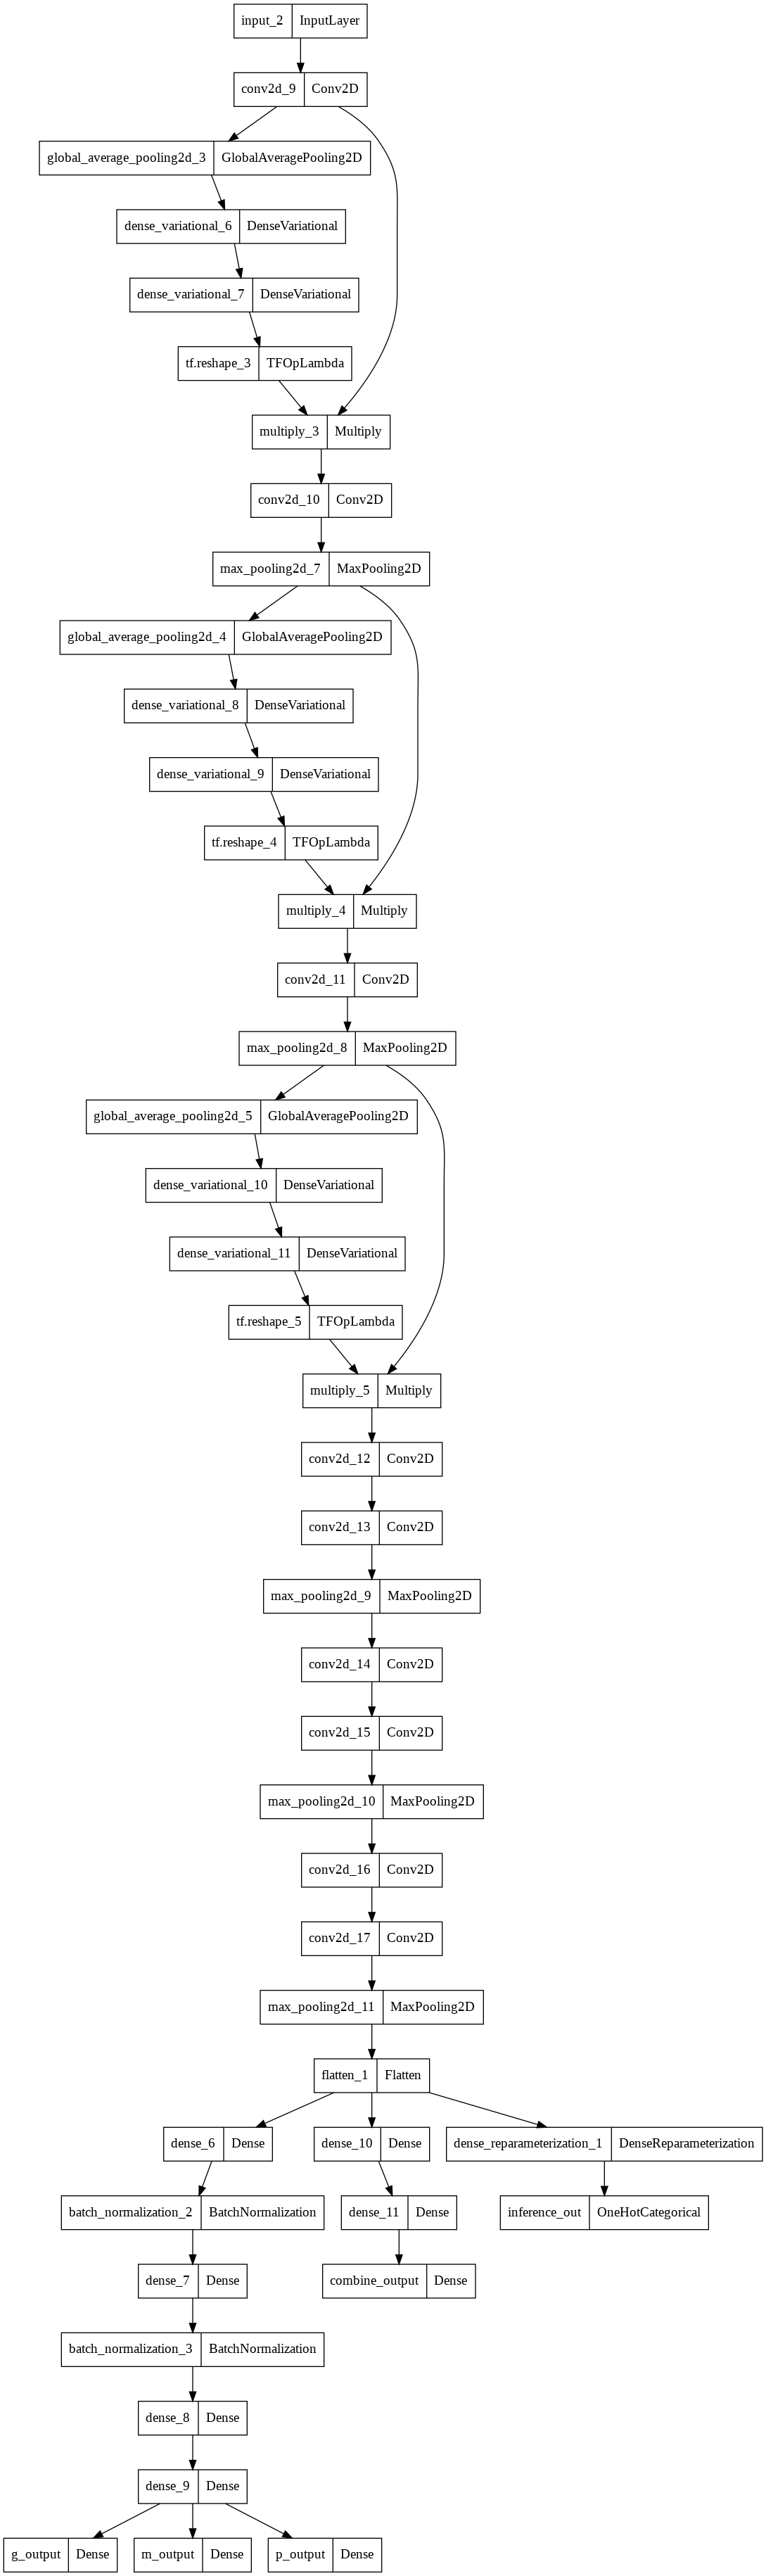

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(BI_Based_SE_Architecture_5,to_file='inferen_Model.png')

In [17]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))
BI_Based_SE_Architecture_5.compile(loss =
                      {'g_output':'binary_crossentropy',
                       'm_output':'binary_crossentropy',
                        'p_output':'binary_crossentropy',
                       'combine_output':'sparse_categorical_crossentropy',
                               'inference_out':negative_log_likelihood
                       },
             optimizer = keras.optimizers.Adam(learning_rate=0.005),
             metrics = ['accuracy'])

In [22]:
# os.makedirs('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/Weights')

In [119]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/Weights/best_model.hdf5",
     monitor='loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

In [ ]:
hist_2=BI_Based_SE_Architecture_5.fit(
                   train_images,
                   [TRAINING_LABELS['glioma Tumor'].values,
                    TRAINING_LABELS['meningioma Tumor'].values,
                    TRAINING_LABELS['pituitary Tumor'].values,
                    TRAINING_LABELS['encoded_label'].values,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
                    ]
                   ,
                   epochs=200)

Epoch 1/200
88/88 [==============================] - 11s 67ms/step - loss: 36.1937 - g_output_loss: 0.5255 - m_output_loss: 0.4911 - p_output_loss: 0.3839 - combine_output_loss: 1.0453 - inference_out_loss: 32.3386 - g_output_accuracy: 0.7243 - m_output_accuracy: 0.7586 - p_output_accuracy: 0.8286 - combine_output_accuracy: 0.5121 - inference_out_accuracy: 0.4014
Epoch 2/200
88/88 [==============================] - 6s 67ms/step - loss: 25.6730 - g_output_loss: 0.4507 - m_output_loss: 0.4598 - p_output_loss: 0.2120 - combine_output_loss: 0.6782 - inference_out_loss: 22.5031 - g_output_accuracy: 0.7707 - m_output_accuracy: 0.7643 - p_output_accuracy: 0.9161 - combine_output_accuracy: 0.7032 - inference_out_accuracy: 0.5861
Epoch 3/200
88/88 [==============================] - 6s 68ms/step - loss: 22.1290 - g_output_loss: 0.4005 - m_output_loss: 0.4231 - p_output_loss: 0.1867 - combine_output_loss: 0.5996 - inference_out_loss: 19.1773 - g_output_accuracy: 0.7907 - m_output_accuracy: 0.7846

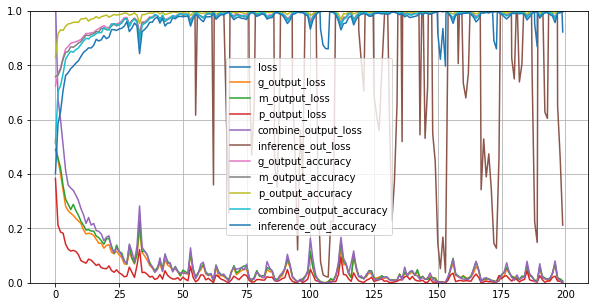

In [26]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [27]:
BI_Based_SE_Architecture_5.evaluate(
          test_images, 
         [TESTING_LABELS['glioma Tumor'].values,
       TESTING_LABELS['meningioma Tumor'].values,
      TESTING_LABELS['pituitary Tumor'].values,
      TESTING_LABELS['encoded_label'].values,
      TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
      ]
       )

9/9 [==============================] - 0s 30ms/step - loss: 8.0761 - g_output_loss: 0.1400 - m_output_loss: 0.1573 - p_output_loss: 0.0088 - combine_output_loss: 0.1947 - inference_out_loss: 6.8824 - g_output_accuracy: 0.9697 - m_output_accuracy: 0.9659 - p_output_accuracy: 0.9962 - combine_output_accuracy: 0.9659 - inference_out_accuracy: 0.9773


[8.076120376586914,
 0.13997846841812134,
 0.15728500485420227,
 0.008829553611576557,
 0.19469359517097473,
 6.882441520690918,
 0.9696969985961914,
 0.9659090638160706,
 0.9962121248245239,
 0.9659090638160706,
 0.9772727489471436]

In [48]:
from tensorflow.keras.models import save_model

## Binary Seperable Problem Report

In [28]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['glioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[0])))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       151
         1.0       0.98      0.96      0.97       113

    accuracy                           0.97       264
   macro avg       0.97      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264



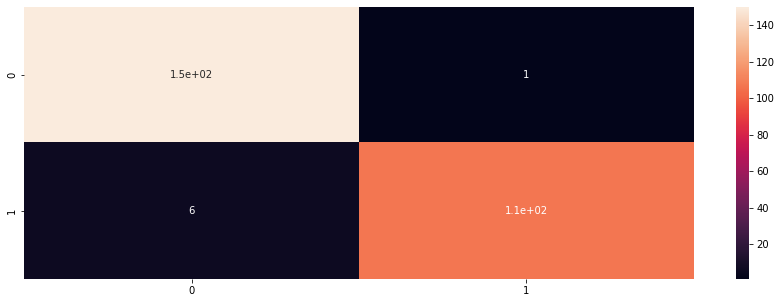

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(TESTING_LABELS['glioma Tumor'],np.round(BI_Based_SE_Architecture_5.predict(test_images)[0])),annot=True)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[1])))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       199
         1.0       0.91      0.97      0.94        65

    accuracy                           0.97       264
   macro avg       0.95      0.97      0.96       264
weighted avg       0.97      0.97      0.97       264



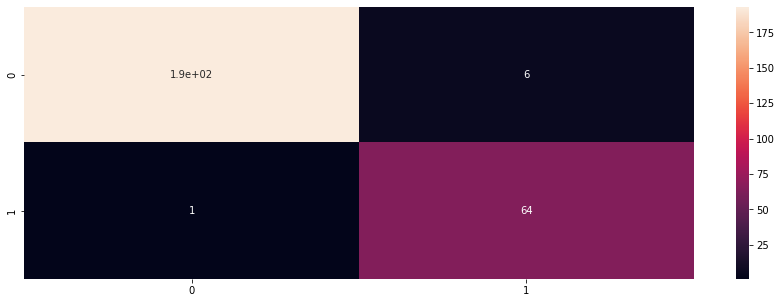

In [67]:
sns.heatmap(confusion_matrix(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[1])),annot=True)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[2])))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       178
         1.0       1.00      0.99      0.99        86

    accuracy                           1.00       264
   macro avg       1.00      0.99      1.00       264
weighted avg       1.00      1.00      1.00       264



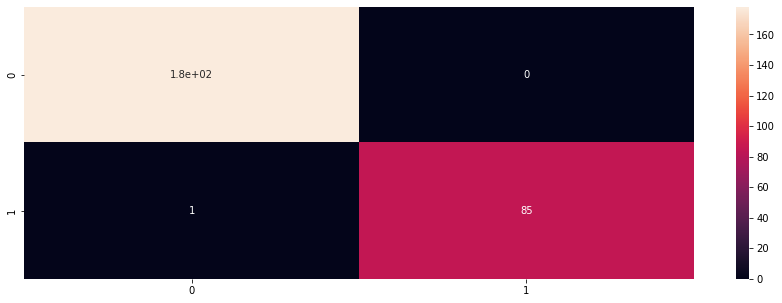

In [68]:
sns.heatmap(confusion_matrix(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5.predict(test_images)[2])),annot=True)

## Multi Class Model Repot

In [31]:
from sklearn.metrics import classification_report
p=np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[3]))[1]
print(classification_report(TESTING_LABELS['encoded_label'].values,
      p
                 ))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       113
           1       0.88      0.98      0.93        65
           2       1.00      0.99      0.99        86

    accuracy                           0.96       264
   macro avg       0.96      0.97      0.96       264
weighted avg       0.97      0.96      0.96       264



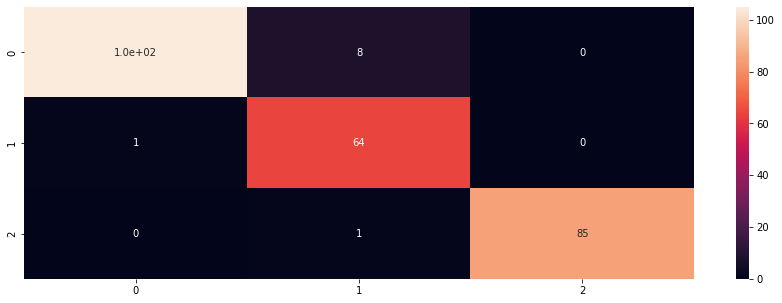

In [69]:
sns.heatmap(confusion_matrix(TESTING_LABELS['encoded_label'].values,p),annot=True)

## Inference Based Model Report

In [32]:
from sklearn.metrics import classification_report
print(classification_report(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[4]))[1]
                 ))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       113
           1       0.89      0.95      0.92        65
           2       1.00      0.97      0.98        86

    accuracy                           0.96       264
   macro avg       0.95      0.96      0.96       264
weighted avg       0.96      0.96      0.96       264



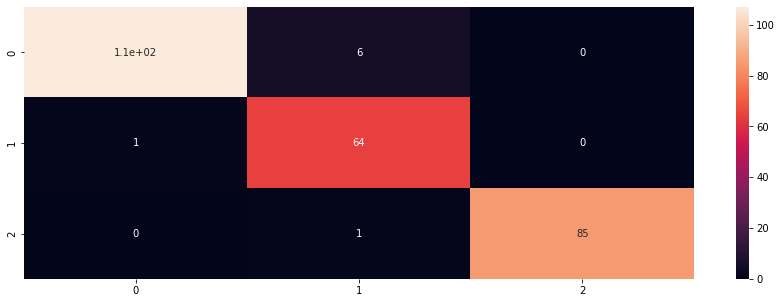

In [72]:
sns.heatmap(confusion_matrix(
    np.where(TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values)[1],
      np.where(np.round(BI_Based_SE_Architecture_5.predict(test_images)[4]))[1]),annot=True)

## Entanglement

First Model Results

In [33]:
u=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[0:3]).reshape(264,3)))[1]

In [34]:
u.shape

(264,)

Second Model Result

In [35]:
v=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[3])))[1]
v.shape

(264,)

3rd Model Results

In [36]:
w=np.where(np.round(np.array(BI_Based_SE_Architecture_5.predict(test_images)[4])))[1]
w.shape

(264,)

Entanglement

In [37]:
u_=np.array([ i[0] for i in u.reshape(264,1)])
v_=np.array([ i[0] for i in v.reshape(264,1)])
w_=np.array([ i[0] for i in w.reshape(264,1)])

In [38]:
Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TESTING_LABELS['encoded_label'].values})

In [39]:
Entangled_Results.head(8)

,Model_u,Model_v,Model_w,Actual
0,1,2,2,2
1,2,1,1,1
2,0,1,1,1
3,2,2,2,2
4,0,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,2,2,2


In [40]:
from scipy import stats
Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])

In [41]:
Entangled_Results['entangled_preds']=Entangled_Predictions

In [42]:
Entangled_Results.head(20)

,Model_u,Model_v,Model_w,Actual,entangled_preds
0,1,2,2,2,2
1,2,1,1,1,1
2,0,1,1,1,1
3,2,2,2,2,2
4,0,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,2,2,2,2
8,2,0,0,0,0
9,0,2,2,2,2


In [43]:
print(classification_report(TESTING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       113
           1       0.96      0.98      0.97        65
           2       1.00      0.98      0.99        86

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.99      0.98      0.98       264



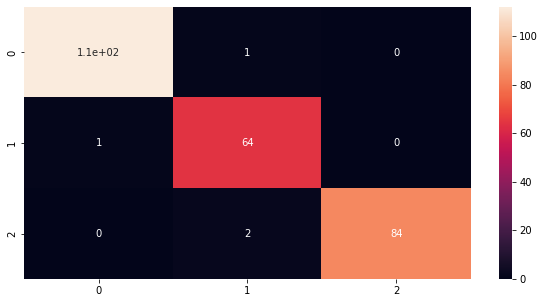

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(Entangled_Results['Actual'],Entangled_Results['entangled_preds']),annot=True)

In [78]:
def ENTNGLED_MODEL(BI_Based_SE_Architecture_):
  u=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[0:3]).reshape(264,3)))[1]
  v=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[3])))[1]
  w=np.where(np.round(np.array(BI_Based_SE_Architecture_.predict(test_images)[4])))[1]
  u_=np.array([ i[0] for i in u.reshape(264,1)])
  v_=np.array([ i[0] for i in v.reshape(264,1)])
  w_=np.array([ i[0] for i in w.reshape(264,1)])
  Entangled_Results=pd.DataFrame({'Model_u':u_,'Model_v':v_,'Model_w':w_,'Actual':TESTING_LABELS['encoded_label'].values})
  Entangled_Predictions=np.array([stats.mode(i)[0][0] for i in Entangled_Results.values])
  Entangled_Results['entangled_preds']=Entangled_Predictions
  print(classification_report(TESTING_LABELS['encoded_label'].values,Entangled_Results['entangled_preds']))
  return Entangled_Results


## Architecture with Small Size 

In [50]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [51]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(Hidden_1)
Attension_1=SE_BLOCK(Hidden_1,64)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(con_1)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu')(pad_1)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(con_2)

Flat=keras.layers.Flatten()(pad_2)

Dense_1=keras.layers.Dense(128,activation='relu')(Flat)
Dense_2=keras.layers.Dense(64,activation='relu')(Dense_1)
output_1=keras.layers.Dense(1,activation='sigmoid',name='g_output')(Dense_2)
output_2=keras.layers.Dense(1,activation='sigmoid',name='m_output')(Dense_2)
output_3=keras.layers.Dense(1,activation='sigmoid',name='p_output')(Dense_2)

second_=keras.layers.Dense(258,activation='relu')(Flat)
second__=keras.layers.Dense(64,activation='relu')(second_)
combined_output=keras.layers.Dense(3,activation='softmax',name='combine_output')(second__)

Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
inferen_output=tfp.layers.OneHotCategorical(3,name='inference_out')(Dense_network)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [52]:
BI_Based_SE_Architecture_5_small=keras.models.Model([Input_],[output_1,output_2,output_3,
                                                        combined_output,
                                                        inferen_output])

In [53]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))
BI_Based_SE_Architecture_5_small.compile(loss =
                      {'g_output':'binary_crossentropy',
                       'm_output':'binary_crossentropy',
                        'p_output':'binary_crossentropy',
                       'combine_output':'sparse_categorical_crossentropy',
                               'inference_out':negative_log_likelihood
                       },
             optimizer = keras.optimizers.Adam(learning_rate=0.005),
             metrics = ['accuracy'])

In [ ]:
hist_2=BI_Based_SE_Architecture_5_small.fit(
                   train_images,
                   [TRAINING_LABELS['glioma Tumor'].values,
                    TRAINING_LABELS['meningioma Tumor'].values,
                    TRAINING_LABELS['pituitary Tumor'].values,
                    TRAINING_LABELS['encoded_label'].values,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
                    ]
                     ,
                   epochs=150)

Epoch 1/150
88/88 [==============================] - 8s 55ms/step - loss: 111.6554 - g_output_loss: 0.5857 - m_output_loss: 0.5461 - p_output_loss: 0.4247 - combine_output_loss: 0.8483 - inference_out_loss: 27.8740 - g_output_accuracy: 0.7168 - m_output_accuracy: 0.7336 - p_output_accuracy: 0.8243 - combine_output_accuracy: 0.6464 - inference_out_accuracy: 0.5675
Epoch 2/150
88/88 [==============================] - 5s 51ms/step - loss: 92.3360 - g_output_loss: 0.3436 - m_output_loss: 0.3675 - p_output_loss: 0.1386 - combine_output_loss: 0.4361 - inference_out_loss: 14.5017 - g_output_accuracy: 0.8293 - m_output_accuracy: 0.8164 - p_output_accuracy: 0.9529 - combine_output_accuracy: 0.8039 - inference_out_accuracy: 0.7261
Epoch 3/150
88/88 [==============================] - 5s 52ms/step - loss: 81.7706 - g_output_loss: 0.2040 - m_output_loss: 0.2350 - p_output_loss: 0.0815 - combine_output_loss: 0.2438 - inference_out_loss: 9.7441 - g_output_accuracy: 0.9000 - m_output_accuracy: 0.8896 

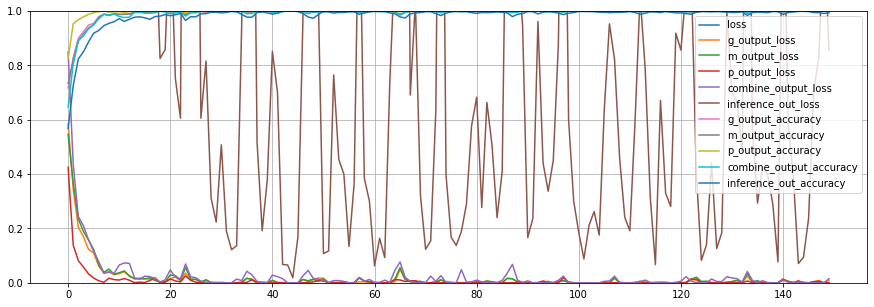

In [61]:
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [73]:
BI_Based_SE_Architecture_5_small.evaluate(
          test_images, 
         [TESTING_LABELS['glioma Tumor'].values,
       TESTING_LABELS['meningioma Tumor'].values,
      TESTING_LABELS['pituitary Tumor'].values,
      TESTING_LABELS['encoded_label'].values,
      TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
      ]
       )

9/9 [==============================] - 0s 23ms/step - loss: 16.2822 - g_output_loss: 0.1966 - m_output_loss: 0.2313 - p_output_loss: 0.0396 - combine_output_loss: 0.2109 - inference_out_loss: 12.7255 - g_output_accuracy: 0.9773 - m_output_accuracy: 0.9735 - p_output_accuracy: 0.9962 - combine_output_accuracy: 0.9735 - inference_out_accuracy: 0.9356


[16.282249450683594,
 0.19663164019584656,
 0.23126402497291565,
 0.03964823856949806,
 0.2108992487192154,
 12.725467681884766,
 0.9772727489471436,
 0.9734848737716675,
 0.9962121248245239,
 0.9734848737716675,
 0.935606062412262]

In [74]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['glioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[0])))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       151
         1.0       0.97      0.97      0.97       113

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264



In [75]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['meningioma Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[1])))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       199
         1.0       0.95      0.94      0.95        65

    accuracy                           0.97       264
   macro avg       0.97      0.96      0.96       264
weighted avg       0.97      0.97      0.97       264



In [76]:
from sklearn.metrics import classification_report
print(classification_report(TESTING_LABELS['pituitary Tumor'],
                          np.round(BI_Based_SE_Architecture_5_small.predict(test_images)[2])))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       178
         1.0       0.99      1.00      0.99        86

    accuracy                           1.00       264
   macro avg       0.99      1.00      1.00       264
weighted avg       1.00      1.00      1.00       264



In [85]:
ret=ENTNGLED_MODEL(BI_Based_SE_Architecture_5_small)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       113
           1       0.97      0.94      0.95        65
           2       0.99      1.00      0.99        86

    accuracy                           0.98       264
   macro avg       0.98      0.97      0.98       264
weighted avg       0.98      0.98      0.98       264



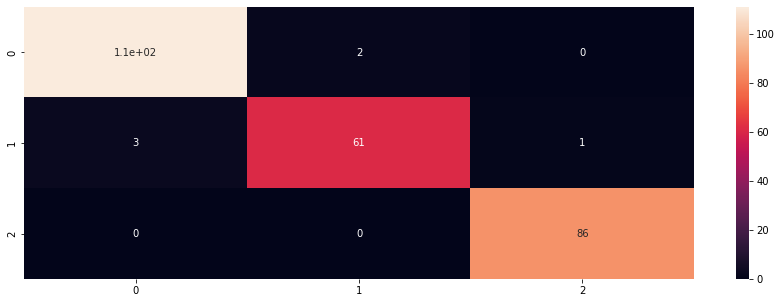

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(ret['Actual'],ret['entangled_preds']),annot=True)